<a href="https://colab.research.google.com/github/shreshtashetty/BufferedASRParakeet/blob/main/tutorials/asr/Buffered_Transducer_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect


NOTE: User is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!pip install fiddle
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
# BRANCH = 'r2.0.0rc0'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
!pip install nemo_toolkit[asr]==2.0.0
!pip install numpy==1.26.4
# Update numba and restart (this is required to update internal numba version of Colab)

# In a conda environment, you would use the following command
# Update Numba to > 0.54
# conda install -c conda-forge numba>=0.54
# or
# conda update -c conda-forge numba>=0.54

# For pip based environments,
# Update Numba to > 0.54
import os
import signal

!pip install --upgrade numba

# This will kill the kernel, click next cell to import the latest numba
os.kill(os.getpid(), signal.SIGKILL)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.2).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
sox is already the newest version (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
  Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cuml-cu12 25.

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyannote-core 6.0.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cuml-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, but you have numba 0.62.1 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Buffered Transducer ASR

There are many approaches to perform streaming/buffered inference for causal CTC / Transducer models. However, it is often observed that causal models sacrifice accuracy to perform streaming evaluation.

In this notebook, similar to the CTC tutorial for [Streaming ASR](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/asr/Streaming_ASR.ipynb), we will tackle the challenge of buffered ASR for long-form speech recognition, but this time we will use Transducer models as the basis for ASR.

You may use this script [ASR Chunked Streaming Inference](https://github.com/NVIDIA/NeMo/blob/stable/examples/asr/asr_chunked_inference/rnnt/speech_to_text_buffered_infer_rnnt.py) to transcribe long audio files with Transducer models.

**Note**: It is highly recommended to review the ``Streaming ASR`` tutorial for a good overview of how streaming/buffered inference works for CTC models and the underlying motivation of streaming ASR itself.

------

Transducers surpass CTC models in speech recognition accuracy when greedy decoding with no LM is used. While CTC models can give better accuracy with beam search decoding and LM, large external language models are required to reach or surpass the accuracy of transducers with greedy decoding.

Moreover, the challenging autoregressive strategy of transducer decoding imposes particular challenges, which we will tackle as a topic in this tutorial.

# Prepare the dataset

We will continue to use the Librispeech dev-clean subset of [Mini Librispeech](https://www.openslr.org/31/).

In [2]:
import os

os.environ['NEMO_DISABLE_CUDA_GRAPHS'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

if not os.path.exists("scripts/get_librispeech_data.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/stable/scripts/dataset_processing/get_librispeech_data.py

In [3]:
# If something goes wrong during data processing, un-comment the following line to delete the cached dataset
# !rm -rf datasets/mini-dev-clean
!mkdir -p datasets/mini-dev-clean

In [4]:
!python scripts/get_librispeech_data.py \
  --data_root "datasets/mini-dev-clean/" \
  --data_sets dev_clean_2 \
  --num_workers=10 \
  --log

INFO:root:

Working on: dev_clean_2
INFO:root:Getting dev_clean_2
INFO:root:Destination datasets/mini-dev-clean/dev_clean_2.tar.gz exists. Skipping.
INFO:root:Extracting dev_clean_2
/content/scripts/get_librispeech_data.py:102: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(data_dir)
INFO:root:Processing dev_clean_2
100% 38/38 [00:02<00:00, 16.50it/s]
INFO:root:Done!


In [5]:
manifest = os.path.join(os.getcwd(), "datasets/mini-dev-clean/dev_clean_2.json")
print("Manifest path :", manifest)

Manifest path : /content/datasets/mini-dev-clean/dev_clean_2.json


Let's create a long audio that is about 15 minutes long by concatenating audio from dev-clean and also create the corresponding concatenated transcript.

In [6]:
import json
def concat_audio(manifest_file, final_len=3600):
    concat_len = 0
    final_transcript = ""
    with open("concat_file.txt", "w") as cat_f:
        while concat_len < final_len:
            with open(manifest_file, "r") as mfst_f:
                for l in mfst_f:
                    row = json.loads(l.strip())
                    if concat_len >= final_len:
                        break
                    cat_f.write(f"file {row['audio_filepath']}\n")
                    final_transcript += (" " + row['text'])
                    concat_len += float(row['duration'])
    return concat_len, final_transcript

In [7]:
new_duration, ref_transcript = concat_audio(manifest, 15*60)

concat_audio_path = os.path.join(os.getcwd(), "datasets/mini-dev-clean/concatenated_audio.wav")

!ffmpeg -t {new_duration} -safe 0 -f concat -i concat_file.txt -c copy -t {new_duration} {concat_audio_path} -y
print("Finished concatenating audio file!")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

# Buffered Transducer

We will now prepare a Conformer Transducer model to set the stage for buffered inference. Conformers possess self-attention layers, which require quadratic cost in terms of memory and compute for a given audio sequence length. Self-attention naturally imposes a limit of 2-5 minute long audio clips, even on 32 GB of GPU memory. Therefore buffered inference is a prime candidate to resolve the issue of Conformer memory consumption.

**Note**: While we primarily discuss buffered ASR here, the primary difference between buffered and streaming ASR is the size of the chunk (which determines the latency of prediction). Many of the techniques here can be tested with smaller chunk and buffer sizes, therefore significantly improving latency and approach  "streaming" mode inference.

In [8]:
import torch
import nemo.collections.asr as nemo_asr
import contextlib
import gc

[NeMo W 2025-11-28 11:57:57 nemo_logging:393] <frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
    


In [8]:
# pretrained_model_name = "stt_en_conformer_transducer_large"

In [9]:
# Clear up memory
torch.cuda.empty_cache()
gc.collect()
# model = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(pretrained_model_name)
model = nemo_asr.models.ASRModel.restore_from("/content/drive/MyDrive/FastConformer-Transducer-BPE.nemo")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'  # You can transcribe even longer samples on the CPU, though it will take much longer !
model = model.to(device)
model.freeze()

[NeMo I 2025-11-28 11:58:56 nemo_logging:381] Tokenizer SentencePieceTokenizer initialized with 9900 tokens


[NeMo W 2025-11-28 11:59:02 nemo_logging:393] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /workspace/parakeet_finetune_scripts/train_manifest_full_8.json
    sample_rate: 16000
    batch_size: 4
    shuffle: true
    num_workers: 8
    pin_memory: true
    max_duration: 30.0
    min_duration: 5
    is_tarred: false
    tarred_audio_filepaths: null
    shuffle_n: 2048
    bucketing_strategy: fully_randomized
    bucketing_batch_size: null
    
[NeMo W 2025-11-28 11:59:02 nemo_logging:393] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /workspace/parakeet_finetune_scripts/val_manifest_full_8.json
    sample_rate: 1

[NeMo I 2025-11-28 11:59:02 nemo_logging:381] PADDING: 0
[NeMo I 2025-11-28 11:59:13 nemo_logging:381] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'clamp': -1.0, 'fastemit_lambda': 0.0}
[NeMo I 2025-11-28 11:59:13 nemo_logging:381] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'clamp': -1.0, 'fastemit_lambda': 0.0}


[NeMo W 2025-11-28 11:59:13 nemo_logging:393] <frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.
    
[NeMo W 2025-11-28 11:59:13 nemo_logging:393] /usr/local/lib/python3.12/dist-packages/nemo/core/utils/cuda_python_utils.py:34: FutureWarning: accessing cuda.__version__ is deprecated, please switch to use cuda.bindings.__version__ instead
      from cuda import __version__ as cuda_python_version
    


[NeMo I 2025-11-28 11:59:13 nemo_logging:381] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'clamp': -1.0, 'fastemit_lambda': 0.0}
[NeMo I 2025-11-28 11:59:37 nemo_logging:381] Model EncDecRNNTBPEModel was successfully restored from /content/drive/MyDrive/FastConformer-Transducer-BPE.nemo.


In [10]:
# Helper for torch amp autocast
if torch.cuda.is_available():
    autocast = torch.cuda.amp.autocast
else:
    @contextlib.contextmanager
    def autocast():
        print("AMP was not available, using FP32!")
        yield

The call to transcribe() below should fail with a "CUDA out of memory" error when run on a GPU with 32 GB memory.

In [11]:
with autocast():
  if torch.cuda.is_available():
    transcript = model.transcribe([concat_audio_path], batch_size=1)[0]

AMP was not available, using FP32!


## Offline Baseline

Let us check the offline score of this model (on the individual segmented audio files) so that we have a baseline. This will evaluate if the buffered inference significantly sacrifices recognition accuracy.

Note that it is often the case that such clean audio segments will not be available (unless it is a preprocessed dataset). Still, we are lucky since we are using Librispeech, which has been nearly perfectly segmented for our use case.

------

Let's download some scripts from the NeMo repo to easily score our model on this dataset in an offline manner.

**Note**: It may take a few minutes to transcribe all the files due to network I/O on Colab. You may choose to uncomment and run the offline evaluation or continue on to the next cell.

In [14]:
if not os.path.exists("scripts/transcribe_speech.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/stable/examples/asr/transcribe_speech.py

if not os.path.exists("scripts/speech_to_text_eval.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/stable/examples/asr/speech_to_text_eval.py

--2025-11-27 11:40:31--  https://raw.githubusercontent.com/NVIDIA/NeMo/stable/examples/asr/transcribe_speech.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21387 (21K) [text/plain]
Saving to: ‘scripts/transcribe_speech.py’

transcribe_speech.p 100%[===================>]  20.89K  --.-KB/s    in 0.001s  

2025-11-27 11:40:31 (28.1 MB/s) - ‘scripts/transcribe_speech.py’ saved [21387/21387]

--2025-11-27 11:40:32--  https://raw.githubusercontent.com/NVIDIA/NeMo/stable/examples/asr/speech_to_text_eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting respon

In [5]:
# # Uncomment if you want to run the evaluation in offline mode
# if torch.cuda.is_available():
#   !python scripts/speech_to_text_eval.py \
#     pretrained_name={pretrained_model_name} \
#     dataset_manifest={manifest} \
#     batch_size=32 \
#     amp=True \
#     use_cer=False
# else:
#   print("CUDA not available, decoding full dataset would take too long.")

In [11]:
# Clear up memory
torch.cuda.empty_cache()
gc.collect()

269777

## Buffer mechanism for streaming long audio files

As you will note below, audio chunking and buffering are identical steps for CTC and Transducer models. As such, we will perform the setup steps in the next cell without significant elaboration.

**Note**: For detailed information on how audio is chunked and evaluated, you should refer to the ``Streaming ASR`` tutorial.

In [12]:
#@title Setup Audio Chunk Iterator
# A simple iterator class to return successive chunks of samples
class AudioChunkIterator():
    def __init__(self, samples, frame_len, sample_rate):
        self._samples = samples
        self._chunk_len = chunk_len_in_secs*sample_rate
        self._start = 0
        self.output=True

    def __iter__(self):
        return self

    def __next__(self):
        if not self.output:
            raise StopIteration
        last = int(self._start + self._chunk_len)
        if last <= len(self._samples):
            chunk = self._samples[self._start: last]
            self._start = last
        else:
            chunk = np.zeros([int(self._chunk_len)], dtype='float32')
            samp_len = len(self._samples) - self._start
            chunk[0:samp_len] = self._samples[self._start:len(self._samples)]
            self.output = False

        return chunk

# a helper function for extracting samples as a numpy array from the audio file
import soundfile as sf
def get_samples(audio_file, target_sr=16000):
    with sf.SoundFile(audio_file, 'r') as f:
        sample_rate = f.samplerate
        samples = f.read()
        if sample_rate != target_sr:
            samples = librosa.core.resample(samples, orig_sr=sample_rate, target_sr=target_sr)
        samples = samples.transpose()
        return samples



In [13]:
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import numpy as np

samples = get_samples(concat_audio_path)
sample_rate  = model.preprocessor._cfg['sample_rate']

## Batched Chunk Processor

First, we write a batched variant of the ``FeatureFrameBufferer`` that was written implicitly as part of the ``Streaming ASR`` tutorial.

The difference between the two versions is - the ``FeatureFrameBufferer`` will buffer across frames of a single sample and then loop for each sample in the dataset. The `BatchedFeatureFrameBufferer` will buffer across the dependent frames of the independent batch of samples. This significantly improves the efficiency of buffered transducer inference.

In [14]:
#@title Setup batched feature chunk bufferer

from nemo.collections.asr.parts.utils import streaming_utils
from torch.utils.data import DataLoader

class BatchedFeatureFrameBufferer(streaming_utils.BatchedFeatureFrameBufferer):
    """
    Batched variant of FeatureFrameBufferer where batch dimension is the independent audio samples.
    """

    def reset(self):
        '''
        Reset frame_history and decoder's state
        '''
        super().reset()
        self.limit_frames = [None for _ in range(self.batch_size)]

    def get_batch_frames(self):
        # Exit if all buffers of all samples have been processed
        if all(self.signal_end):
            return []

        # Otherwise sequentially process frames of each sample one by one.
        batch_frames = []
        for idx, frame_reader in enumerate(self.all_frame_reader):

            limit_frames = self.limit_frames[idx]
            try:
                if limit_frames is not None and self.buffer_number >= limit_frames:
                  raise StopIteration()

                frame = next(frame_reader)
                frame = np.copy(frame)

                batch_frames.append(frame)
            except StopIteration:
                # If this sample has finished all of its buffers
                # Set its signal_end flag, and assign it the id of which buffer index
                # did it finish the sample (if not previously set)
                # This will let the alignment module know which sample in the batch finished
                # at which index.
                batch_frames.append(None)
                self.signal_end[idx] = True

                if self.signal_end_index[idx] is None:
                    self.signal_end_index[idx] = self.buffer_number

        self.buffer_number += 1
        return batch_frames

    def set_frame_reader(self, frame_reader, idx, limit_frames=None):
        self.all_frame_reader[idx] = frame_reader
        self.signal_end[idx] = False
        self.signal_end_index[idx] = None
        self.limit_frames[idx] = limit_frames

## Batched and Buffered ASR Transducer

Next, we will build the actual buffered transducer evaluation class.


Similar to Streaming CTC models, we pick tokens corresponding to one chunk length of audio for each buffer. The chunk within each buffer is chosen such that there is equal left and right context available to the audio within the chunk.


Since this is a batched variant of the ``Streaming ASR`` tutorial, we will subclass the required method and override the parts that we need to support batching across independent samples and buffering across dependent frames per sample in the batch.

----

Due to the complexity of the code, we will hide the cell below then explain the essential sections of the code as sub-sections. If at any point you would like to review the code itself, click `Show code` below.

In [54]:
# #@title Setup batched and buffered transducer ASR code

# import librosa

# def inplace_buffer_merge(buffer, data, timesteps, model):
#     """
#     Merges the new text from the current frame with the previous text contained in the buffer.

#     The alignment is based on a Longest Common Subsequence algorithm, with some additional heuristics leveraging
#     the notion that the chunk size is >= the context window. In case this assumptio is violated, the results of the merge
#     will be incorrect (or at least obtain worse WER overall).
#     """
#     # If delay timesteps is 0, that means no future context was used. Simply concatenate the buffer with new data.
#     if timesteps < 1:
#         buffer += data
#         return buffer

#     # If buffer is empty, simply concatenate the buffer and data.
#     if len(buffer) == 0:
#         buffer += data
#         return buffer

#     # Concat data to buffer
#     buffer += data
#     return buffer


# class BatchedFrameASRRNNT(streaming_utils.FrameBatchASR):
#     """
#     Batched implementation of FrameBatchASR for RNNT models, where the batch dimension is independent audio samples.
#     """

#     def __init__(self, asr_model, frame_len=1.6, total_buffer=4.0,
#         batch_size=32, max_steps_per_timestep: int = 5, stateful_decoding: bool = False):
#         '''
#         Args:
#             asr_model: An RNNT model.
#             frame_len: frame's duration, seconds.
#             total_buffer: duration of total audio chunk size, in seconds.
#             batch_size: Number of independent audio samples to process at each step.
#             max_steps_per_timestep: Maximum number of tokens (u) to process per acoustic timestep (t).
#             stateful_decoding: Boolean whether to enable stateful decoding for preservation of state across buffers.
#         '''
#         super().__init__(asr_model, frame_len=frame_len, total_buffer=total_buffer, batch_size=batch_size)

#         # OVERRIDES OF THE BASE CLASS
#         self.max_steps_per_timestep = max_steps_per_timestep
#         self.stateful_decoding = stateful_decoding

#         self.all_alignments = [[] for _ in range(self.batch_size)]
#         self.all_preds = [[] for _ in range(self.batch_size)]
#         self.previous_hypotheses = None
#         self.batch_index_map = {
#             idx: idx for idx in range(self.batch_size)
#         }  # pointer from global batch id : local sub-batch id

#         try:
#             self.eos_id = self.asr_model.tokenizer.eos_id
#         except Exception:
#             self.eos_id = -1

#         print("Performing Stateful decoding :", self.stateful_decoding)

#         # OVERRIDES
#         self.frame_bufferer = BatchedFeatureFrameBufferer(
#             asr_model=asr_model, frame_len=frame_len, batch_size=batch_size, total_buffer=total_buffer
#         )

#         self.reset()

#     def reset(self):
#         """
#         Reset frame_history and decoder's state
#         """
#         super().reset()

#         self.all_alignments = [[] for _ in range(self.batch_size)]
#         self.all_preds = [[] for _ in range(self.batch_size)]
#         self.previous_hypotheses = None
#         self.batch_index_map = {idx: idx for idx in range(self.batch_size)}

#         self.data_layer = [streaming_utils.AudioBuffersDataLayer() for _ in range(self.batch_size)]
#         self.data_loader = [
#             DataLoader(self.data_layer[idx], batch_size=1, collate_fn=streaming_utils.speech_collate_fn)
#             for idx in range(self.batch_size)
#         ]

#         self.buffers = []

#     def read_audio_file(self, audio_filepath: list, delay, model_stride_in_secs):
#         assert len(audio_filepath) == self.batch_size

#         # Read in a batch of audio files, one by one
#         for idx in range(self.batch_size):
#             samples = get_samples(audio_filepath[idx])
#             samples = np.pad(samples, (0, int(delay * model_stride_in_secs * self.asr_model._cfg.sample_rate)))
#             frame_reader = streaming_utils.AudioFeatureIterator(samples, self.frame_len, self.raw_preprocessor, self.asr_model.device)
#             self.set_frame_reader(frame_reader, idx)

#     def set_frame_reader(self, frame_reader, idx, limit_frames = None):
#         self.frame_bufferer.set_frame_reader(frame_reader, idx, limit_frames)

#     @torch.no_grad()
#     def infer_logits(self):
#         frame_buffers = self.frame_bufferer.get_buffers_batch()

#         while len(frame_buffers) > 0:
#             # While at least 1 sample has a buffer left to process
#             self.frame_buffers += frame_buffers[:]

#             for idx, buffer in enumerate(frame_buffers):
#                 if self.plot:
#                   self.buffers.append(buffer[:][0])
#                 self.data_layer[idx].set_signal(buffer[:])

#             self._get_batch_preds()
#             frame_buffers = self.frame_bufferer.get_buffers_batch()

#     @torch.no_grad()
#     def _get_batch_preds(self):
#         """
#         Perform dynamic batch size decoding of frame buffers of all samples.

#         Steps:
#             -   Load all data loaders of every sample
#             -   For all samples, determine if signal has finished.
#                 -   If so, skip calculation of mel-specs.
#                 -   If not, compute mel spec and length
#             -   Perform Encoder forward over this sub-batch of samples. Maintain the indices of samples that were processed.
#             -   If performing stateful decoding, prior to decoder forward, remove the states of samples that were not processed.
#             -   Perform Decoder + Joint forward for samples that were processed.
#             -   For all output RNNT alignment matrix of the joint do:
#                 -   If signal has ended previously (this was last buffer of padding), skip alignment
#                 -   Otherwise, recalculate global index of this sample from the sub-batch index, and preserve alignment.
#             -   Same for preds
#             -   Update indices of sub-batch with global index map.
#             - Redo steps until all samples were processed (sub-batch size == 0).
#         """
#         device = self.asr_model.device

#         data_iters = [iter(data_loader) for data_loader in self.data_loader]

#         feat_signals = []
#         feat_signal_lens = []

#         new_batch_keys = []
#         for idx in range(self.batch_size):
#             if self.frame_bufferer.signal_end[idx]:
#                 continue

#             batch = next(data_iters[idx])
#             feat_signal, feat_signal_len = batch
#             feat_signal, feat_signal_len = feat_signal.to(device), feat_signal_len.to(device)

#             feat_signals.append(feat_signal)
#             feat_signal_lens.append(feat_signal_len)

#             # preserve batch indices
#             new_batch_keys.append(idx)

#         if len(feat_signals) == 0:
#             return

#         feat_signal = torch.cat(feat_signals, 0)
#         feat_signal_len = torch.cat(feat_signal_lens, 0)

#         del feat_signals, feat_signal_lens

#         encoded, encoded_len = self.asr_model(processed_signal=feat_signal, processed_signal_length=feat_signal_len)

#         # filter out partial hypotheses from older batch subset
#         if self.stateful_decoding and self.previous_hypotheses is not None:
#             new_prev_hypothesis = []
#             for new_batch_idx, global_index_key in enumerate(new_batch_keys):
#                 old_pos = self.batch_index_map[global_index_key]
#                 new_prev_hypothesis.append(self.previous_hypotheses[old_pos])
#             self.previous_hypotheses = new_prev_hypothesis

#         best_hyp, _ = self.asr_model.decoding.rnnt_decoder_predictions_tensor(
#             encoded, encoded_len, return_hypotheses=True, partial_hypotheses=self.previous_hypotheses
#         )

#         if self.stateful_decoding:
#             # preserve last state from hypothesis of new batch indices
#             self.previous_hypotheses = best_hyp

#         for idx, hyp in enumerate(best_hyp):
#             global_index_key = new_batch_keys[idx]  # get index of this sample in the global batch

#             has_signal_ended = self.frame_bufferer.signal_end[global_index_key]

#             if not has_signal_ended:
#                 self.all_alignments[global_index_key].append(hyp.alignments)

#         preds = [hyp.y_sequence for hyp in best_hyp]
#         for idx, pred in enumerate(preds):
#             global_index_key = new_batch_keys[idx]  # get index of this sample in the global batch

#             has_signal_ended = self.frame_bufferer.signal_end[global_index_key]
#             if not has_signal_ended:
#                 self.all_preds[global_index_key].append(pred.cpu().numpy())

#         if self.stateful_decoding:
#             # State resetting is being done on sub-batch only, global index information is not being updated
#             reset_states = self.asr_model.decoder.initialize_state(encoded)

#             for idx, pred in enumerate(preds):
#                 if len(pred) > 0 and pred[-1] == self.eos_id:
#                     # reset states :
#                     self.previous_hypotheses[idx].y_sequence = self.previous_hypotheses[idx].y_sequence[:-1]
#                     self.previous_hypotheses[idx].dec_state = self.asr_model.decoder.batch_select_state(
#                         reset_states, idx
#                     )

#         # Position map update
#         if len(new_batch_keys) != len(self.batch_index_map):
#             for new_batch_idx, global_index_key in enumerate(new_batch_keys):
#                 self.batch_index_map[global_index_key] = new_batch_idx  # let index point from global pos -> local pos

#         del encoded, encoded_len
#         del best_hyp, pred

#     # def transcribe(
#     #     self, tokens_per_chunk: int, delay: int, plot=False,
#     # ):
#     #     """
#     #     Performs "middle token" alignment prediction using the buffered audio chunk.
#     #     """
#     #     self.plot = plot
#     #     self.infer_logits()

#     #     self.unmerged = [[] for _ in range(self.batch_size)]
#     #     for idx, alignments in enumerate(self.all_alignments):

#     #         signal_end_idx = self.frame_bufferer.signal_end_index[idx]
#     #         if signal_end_idx is None:
#     #             raise ValueError("Signal did not end")

#     #         all_toks = []

#     #         for a_idx, alignment in enumerate(alignments):
#     #             # alignment = alignment[len(alignment) - 1 - delay : len(alignment) - 1 - delay + tokens_per_chunk]
#     #             ################### ADDED BY ME TO REPLACE MIDDLE TOKEN EXTRACTION ##########################
#     #             # Or try this safer middle token extraction:
#     #             if len(alignment) > 0:
#     #                 # Calculate safe indices
#     #                 total_len = len(alignment)
#     #                 start_idx = max(0, total_len - 1 - delay)
#     #                 end_idx = min(total_len, start_idx + tokens_per_chunk)
#     #                 if start_idx < end_idx:
#     #                     alignment = alignment[start_idx:end_idx]
#     #                 else:
#     #                     alignment = alignment
#     #              ############################################################################################

#     #             ids, toks = self._alignment_decoder(alignment, self.asr_model.tokenizer, self.blank_id)
#     #             all_toks.append(toks)

#     #             if len(ids) > 0 and a_idx < signal_end_idx:
#     #                 self.unmerged[idx] = inplace_buffer_merge(self.unmerged[idx], ids, delay, model=self.asr_model,)

#     #         if plot:
#     #           for i, tok in enumerate(all_toks):
#     #               print("\nGreedy labels collected from this buffer")
#     #               print(tok[len(tok) - 1 - delay:len(tok) - 1 - delay + tokens_per_chunk])
#     #               self.toks_unmerged += tok[len(tok) - 1 - delay:len(tok) - 1 - delay + tokens_per_chunk]
#     #           print("\nTokens collected from successive buffers before RNNT merge")
#     #           print(self.toks_unmerged)

#     #     output = []
#     #     for idx in range(self.batch_size):
#     #         output.append(self.greedy_merge(self.unmerged[idx]))
#         # return output

#     # In the transcribe() method, replace the problematic alignment extraction:
#     def transcribe(self, tokens_per_chunk: int, delay: int, plot=False):
#       self.plot = plot
#       self.infer_logits()

#       self.unmerged = [[] for _ in range(self.batch_size)]
#       for idx, alignments in enumerate(self.all_alignments):

#           signal_end_idx = self.frame_bufferer.signal_end_index[idx]
#           if signal_end_idx is None:
#               raise ValueError("Signal did not end")

#           all_toks = []

#       for a_idx, alignment in enumerate(alignments):
#           if len(alignment) == 0:
#               continue

#           # **FIXED MIDDLE TOKEN EXTRACTION**
#           total_timesteps = len(alignment)

#           # Calculate extraction window more carefully
#           if total_timesteps <= tokens_per_chunk:
#               # If alignment is smaller than expected, take most of it
#               start_idx = max(0, total_timesteps // 4)  # Skip first 25%
#               end_idx = total_timesteps
#           else:
#               # For larger alignments, use improved middle extraction
#               # Instead of the problematic calculation, use a simpler approach:
#               middle_start = total_timesteps // 3  # Start at 33% point
#               middle_end = min(total_timesteps, middle_start + tokens_per_chunk)
#               start_idx = middle_start
#               end_idx = middle_end

#           # Safely extract the middle portion
#           if start_idx < end_idx and start_idx < len(alignment):
#               extracted_alignment = alignment[start_idx:end_idx]
#           else:
#               extracted_alignment = alignment  # Fallback to full alignment

#           print(f"DEBUG: Total alignment: {len(alignment)}, extracted: {len(extracted_alignment)} (indices {start_idx}:{end_idx})")

#           ids, toks = self._alignment_decoder(extracted_alignment, self.asr_model.tokenizer, self.blank_id)
#           all_toks.append(toks)

#           if len(ids) > 0 and a_idx < signal_end_idx:
#               self.unmerged[idx] = inplace_buffer_merge(self.unmerged[idx], ids, delay, model=self.asr_model)

#       if plot:
#           for i, tok in enumerate(all_toks):
#               print("\nGreedy labels collected from this buffer")
#               print(tok[len(tok) - 1 - delay:len(tok) - 1 - delay + tokens_per_chunk])
#               self.toks_unmerged += tok[len(tok) - 1 - delay:len(tok) - 1 - delay + tokens_per_chunk]
#           print("\nTokens collected from successive buffers before RNNT merge")
#           print(self.toks_unmerged)

#       output = []
#       for idx in range(self.batch_size):
#           output.append(self.greedy_merge(self.unmerged[idx]))
#       return output


#     def _alignment_decoder(self, alignments, tokenizer, blank_id):
#         s = []
#         ids = []

#         for t in range(len(alignments)):
#             for u in range(len(alignments[t])):
#                 token_id = int(alignments[t][u][1])
#                 if token_id != blank_id:
#                     token = tokenizer.ids_to_tokens([token_id])[0]
#                     s.append(token)
#                     ids.append(token_id)

#                 else:
#                     # blank token
#                     pass

#         return ids, s

#     def greedy_merge(self, preds):
#         decoded_prediction = [p for p in preds]
#         hypothesis = self.asr_model.tokenizer.ids_to_text(decoded_prediction)
#         return hypothesis

In [29]:
#@title Setup batched and buffered transducer ASR code

import librosa

def inplace_buffer_merge(buffer, data, timesteps, model):
    """
    Merges the new text from the current frame with the previous text contained in the buffer.

    The alignment is based on a Longest Common Subsequence algorithm, with some additional heuristics leveraging
    the notion that the chunk size is >= the context window. In case this assumptio is violated, the results of the merge
    will be incorrect (or at least obtain worse WER overall).
    """
    # If delay timesteps is 0, that means no future context was used. Simply concatenate the buffer with new data.
    if timesteps < 1:
        buffer += data
        return buffer

    # If buffer is empty, simply concatenate the buffer and data.
    if len(buffer) == 0:
        buffer += data
        return buffer

    # Concat data to buffer
    buffer += data
    return buffer


class BatchedFrameASRRNNT(streaming_utils.FrameBatchASR):
    """
    Simplified implementation that avoids complex alignment extraction
    """

    def __init__(self, asr_model, frame_len=1.6, total_buffer=4.0,
        batch_size=32, max_steps_per_timestep: int = 5, stateful_decoding: bool = False):
        '''Same init as before'''
        super().__init__(asr_model, frame_len=frame_len, total_buffer=total_buffer, batch_size=batch_size)

        self.max_steps_per_timestep = max_steps_per_timestep
        self.stateful_decoding = stateful_decoding

        # Store full transcriptions instead of alignments
        self.buffer_transcriptions = [[] for _ in range(self.batch_size)]
        self.previous_hypotheses = None
        self.batch_index_map = {idx: idx for idx in range(self.batch_size)}

        try:
            self.eos_id = self.asr_model.tokenizer.eos_id
        except Exception:
            self.eos_id = -1

        print("Performing Stateful decoding :", self.stateful_decoding)

        self.frame_bufferer = BatchedFeatureFrameBufferer(
            asr_model=asr_model, frame_len=frame_len, batch_size=batch_size, total_buffer=total_buffer
        )

        self.reset()

    def reset(self):
        """Reset frame_history and decoder's state"""
        super().reset()

        self.buffer_transcriptions = [[] for _ in range(self.batch_size)]
        self.previous_hypotheses = None
        self.batch_index_map = {idx: idx for idx in range(self.batch_size)}

        self.data_layer = [streaming_utils.AudioBuffersDataLayer() for _ in range(self.batch_size)]
        self.data_loader = [
            DataLoader(self.data_layer[idx], batch_size=1, collate_fn=streaming_utils.speech_collate_fn)
            for idx in range(self.batch_size)
        ]
        self.buffers = []

    def set_frame_reader(self, frame_reader, idx, limit_frames=None):
        self.frame_bufferer.set_frame_reader(frame_reader, idx, limit_frames)

    @torch.no_grad()
    def infer_logits(self):
        frame_buffers = self.frame_bufferer.get_buffers_batch()

        while len(frame_buffers) > 0:
            self.frame_buffers += frame_buffers[:]

            for idx, buffer in enumerate(frame_buffers):
                if self.plot:
                    self.buffers.append(buffer[:][0])
                self.data_layer[idx].set_signal(buffer[:])

            self._get_batch_preds()
            frame_buffers = self.frame_bufferer.get_buffers_batch()

    @torch.no_grad()
    def _get_batch_preds(self):
        """Get full transcription of each buffer (simplified approach)"""
        device = self.asr_model.device
        data_iters = [iter(data_loader) for data_loader in self.data_loader]

        feat_signals = []
        feat_signal_lens = []
        new_batch_keys = []

        for idx in range(self.batch_size):
            if self.frame_bufferer.signal_end[idx]:
                continue

            batch = next(data_iters[idx])
            feat_signal, feat_signal_len = batch
            feat_signal, feat_signal_len = feat_signal.to(device), feat_signal_len.to(device)

            feat_signals.append(feat_signal)
            feat_signal_lens.append(feat_signal_len)
            new_batch_keys.append(idx)

        if len(feat_signals) == 0:
            return

        feat_signal = torch.cat(feat_signals, 0)
        feat_signal_len = torch.cat(feat_signal_lens, 0)

        encoded, encoded_len = self.asr_model(processed_signal=feat_signal, processed_signal_length=feat_signal_len)

        # Get full transcriptions (no complex alignment extraction)
        best_hyp, _ = self.asr_model.decoding.rnnt_decoder_predictions_tensor(
            encoded, encoded_len, return_hypotheses=False, partial_hypotheses=None
        )

        # Store full transcription of each buffer
        for idx, hyp in enumerate(best_hyp):
            global_index_key = new_batch_keys[idx]
            has_signal_ended = self.frame_bufferer.signal_end[global_index_key]

            if not has_signal_ended:
                full_text = hyp  # This is the complete transcription
                self.buffer_transcriptions[global_index_key].append(full_text)

        del encoded, encoded_len, feat_signal, feat_signal_len

    def transcribe(self, tokens_per_chunk: int, delay: int, plot=False):
        """Simple transcription with overlap removal"""
        self.plot = plot
        self.infer_logits()

        output = []
        for idx in range(self.batch_size):
            buffer_texts = self.buffer_transcriptions[idx]

            if plot:
                print("\n=== RAW BUFFER TRANSCRIPTIONS ===")
                for i, text in enumerate(buffer_texts):
                    print(f"Buffer {i}: '{text}'")

            # Remove overlaps between consecutive buffers
            final_text = self.remove_buffer_overlaps(buffer_texts)
            output.append(final_text)

        return output

    def remove_buffer_overlaps(self, buffer_texts, min_overlap_words=2):
      """Improved overlap removal with fuzzy matching"""
      if len(buffer_texts) <= 1:
          return " ".join(buffer_texts)

      print(f"\n=== OVERLAP REMOVAL DEBUG ===")

      # Start with first buffer
      result_words = buffer_texts[0].split()
      print(f"Starting with: '{' '.join(result_words)}'")

      for i in range(1, len(buffer_texts)):
          current_words = buffer_texts[i].split()

          if not current_words:
              continue

          print(f"\nBuffer {i}: '{' '.join(current_words)}'")
          print(f"Looking for overlap with: '{' '.join(result_words[-8:])}'")  # Last 8 words

          # Find overlap by checking if any suffix of result matches any prefix of current
          best_overlap = 0

          # Check from longest possible overlap down to minimum
          max_check = min(len(result_words), len(current_words), 10)  # Check up to 10 words

          for overlap_len in range(max_check, min_overlap_words - 1, -1):
              result_suffix = result_words[-overlap_len:]
              current_prefix = current_words[:overlap_len]

              # Allow for slight differences (case, punctuation)
              result_clean = [w.lower().strip('.,!?') for w in result_suffix]
              current_clean = [w.lower().strip('.,!?') for w in current_prefix]

              if result_clean == current_clean:
                  best_overlap = overlap_len
                  print(f"Found overlap of {overlap_len} words: {result_suffix} == {current_prefix}")
                  break

          # Add non-overlapping portion
          new_words = current_words[best_overlap:]
          if new_words:  # Only add if there are new words
              result_words.extend(new_words)
              print(f"Added: '{' '.join(new_words)}'")
          else:
              print("No new words to add (complete overlap)")

      final_result = " ".join(result_words)
      print(f"\n=== FINAL RESULT ===")
      print(f"'{final_result}'")
      return final_result

## Code Breakdown

The following section is optional and describes the sub-sections of the code snippet above. It can improve understanding of how the code above works.

### Code: `__init__`

Transducers will operate on a batch of samples at once and then process the chunks of each of these samples independently with a single forward pass of the Encoder and then multiple autoregressive calls to the Prediction Network + Joint Network.

### Code: `_alignment_decoder(alignments, tokenizer, blank_id)`

Since the models we are evaluating are trained with sub-word encoding, we will need to decode the tokens to a text format from the 2-dimensional dangling array, which represents the alignments of the transducer's prediction.

**Note**: The alignment is a 2-dimensional dangling array with the shape `Ti x Uj`; there can be any number of `Uj` per `Ti`. The alignment also contains the id for the `Transducer Blank` token - which we need to remove during decoding to prevent the tokenizer from trying to decode an invalid id. An example of a transducer alignment will be presented at the end of the notebook.

### Code: `_get_batch_preds()`

The core of the transducer model's decoding step per chunk of provided audio for all independent audio samples. We batch together the independent acoustic segments through the encoder and then batch process the prediction net + joint net to improve the GPU efficiency of decoding.

To further improve efficiency, we will perform adaptive batching during evaluation. In adaptive batching, once a sample has finished processing its audio sequence, it will be removed from the global set of all samples that should be processed. After each chunk is processed of each sample, the completed samples are removed from the next round of decoding.

------

Due to this additional complexity, we break down a few steps of this process below -

#### Select the subset of samples that need to finish processing

We will loop through all samples, checking if the sample has finished processing or not. If not, it will be added to the pool of samples that must be processed. These samples are passed through the encoder.

```python
new_batch_keys = []
for idx in range(self.batch_size):
    if self.frame_bufferer.signal_end[idx]:
        continue
    batch = next(data_iters[idx])
    ...
    new_batch_keys.append(idx)
encoded, encoded_len = self.asr_model(processed_signal=feat_signal, processed_signal_length=feat_signal_len)
```

#### Update partial states of the model and decode the prediction + joint steps

If stateful decoding is being performed, update the states partially. In this step, we select the indices of states that existed in this sub-batch only.

After this, we perform regular transducer decoding of the Prediction Network + Joint Network. Since it is being done on a subset of samples, it is much faster than padded decoding.

```python
best_hyp, _ = self.asr_model.decoding.rnnt_decoder_predictions_tensor(
    encoded, encoded_len, return_hypotheses=True, partial_hypotheses=self.previous_hypotheses
)
```

#### Preserve the alignments

Now that we have the model's hypotheses, we need to preserve the alignments in the correct global index. Remember, we originally had a batch size (say B), but now we performed an inference step over just a sub-batch (say $B'$; $B' ≤ B$), so we need to de-reference the ids of this sub-batch $B'$ to the actual ids in $B$.

We utilize `global_index_key = new_batch_keys[idx]` which we built when we were sub-sampling the chunks themselves.

```python
 for idx, hyp in enumerate(best_hyp):
    global_index_key = new_batch_keys[idx]  # get index of this sample in the global batch
    has_signal_ended = self.frame_bufferer.signal_end[global_index_key]
    if not has_signal_ended:
        self.all_alignments[global_index_key].append(hyp.alignments)
```

#### Update the index mapping from local sub-batch to global batch

If, in the current step, the sub-batch $B'$ was smaller than the original batch size $B$, then we need to update the index that is tracked by `self.batch_index_map`.

`self.batch_index_map` is a mapping from the global batch index to the current local batch index.

```python
# Position map update
if len(new_batch_keys) != len(self.batch_index_map):
    for new_batch_idx, global_index_key in enumerate(new_batch_keys):
        self.batch_index_map[global_index_key] = new_batch_idx  # let index point from global pos -> local pos

```

------
You may wonder, why do we need to preserve this information?

Consider the case where you have five samples in the original global batch size $B$. Let their ids be - `[0, 1, 2, 3, 4]`.

After a few steps, the ids `2` and `3` finished processing and are no longer part of sub-batch $B'$. So the new sub-batch is `[0, 1, 4]`.

Now - index `sub_batch[2]` no longer corresponds to sample `[2]` but instead to sample `[4]`. Therefore, this information is preserved in `self.batch_index_map` where the key is the global index id (0-5) and the value is the index of this sample in the current sub-batch (0,1,4).

-----


### Code: `transcribe(tokens_per_chunk, delay)`

The method that actually performs transcriptions on chunks of audio segments. It loops two layers - the samples per batch and the alignments per chunk in each of these samples.


```python
self.unmerged = [[] for _ in range(self.batch_size)]
for idx, alignments in enumerate(self.all_alignments):
    signal_end_idx = self.frame_bufferer.signal_end_index[idx]
    for a_idx, alignment in enumerate(alignments):
        # The core of the "middle token" algorithm for buffered ASR.
        alignment = alignment[len(alignment) - 1 - delay : len(alignment) - 1 - delay + tokens_per_chunk]
        ids, toks = self._alignment_decoder(alignment, self.asr_model.tokenizer, self.blank_id)
        if len(ids) > 0 and a_idx < signal_end_idx:
            self.unmerged[idx] = inplace_buffer_merge(self.unmerged[idx], ids, delay, model=self.asr_model)
...
output = []
for idx in range(self.batch_size):
    output.append(self.greedy_merge(self.unmerged[idx]))
```

## Evaluation


Let's call the decoder with a few buffers we create from our long audio file to see how this chunk-based decoder comes together. Some interesting experiments to try would be to see how changing sizes of the chunk and the context affect transcription accuracy.

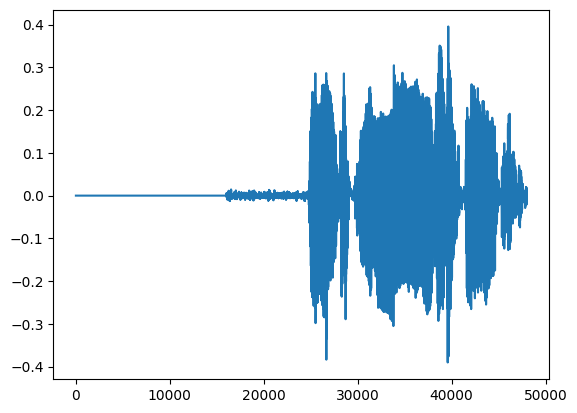

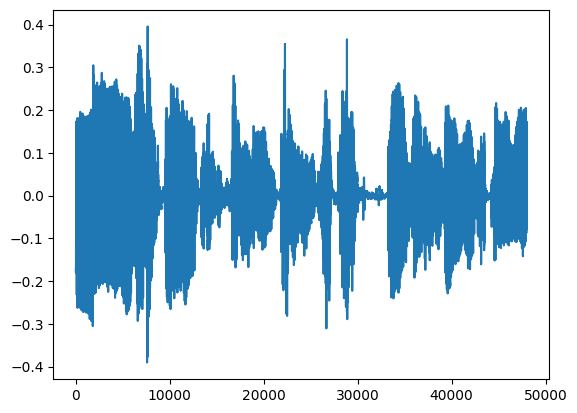

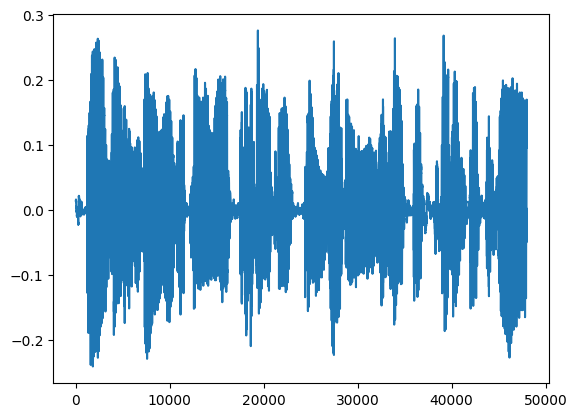

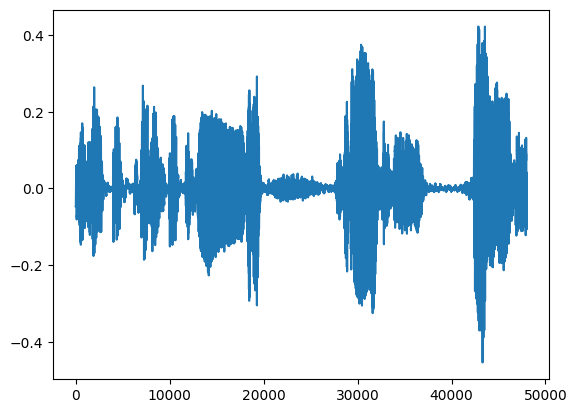

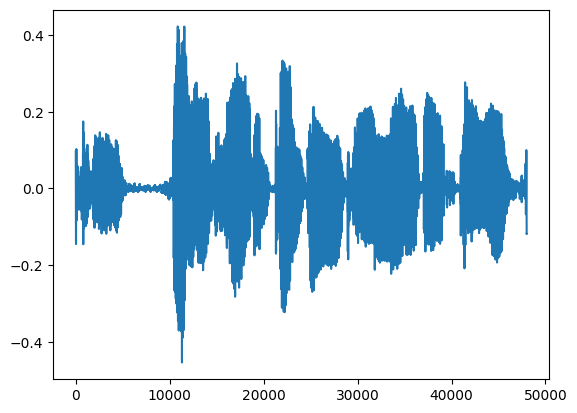

In [30]:
# chunk_len_in_secs: float = 8.0
# context_len_in_secs: float = 1.0
chunk_len_in_secs: float = 2.0
context_len_in_secs: float = 0.5

# max_steps_per_timestep: int = 5
max_steps_per_timestep: int = 4
stateful_decoding: bool = False


##########################################################################
buffer_len_in_secs = chunk_len_in_secs + 2* context_len_in_secs

n_buffers = 5

buffer_len = int(sample_rate*buffer_len_in_secs)
sampbuffer = np.zeros([buffer_len], dtype=np.float32)

chunk_reader = AudioChunkIterator(samples, chunk_len_in_secs, sample_rate)
chunk_len = int(sample_rate*chunk_len_in_secs)
count = 0
buffer_list = []
for chunk in chunk_reader:
    count +=1
    sampbuffer[:-chunk_len] = sampbuffer[chunk_len:]
    sampbuffer[-chunk_len:] = chunk
    buffer_list.append(np.array(sampbuffer))

    plt.plot(buffer_list[-1])
    plt.show()

    display(Audio(sampbuffer, rate=16000))
    if count >= n_buffers:
        break


## Change Decoding Strategy for Transducer Model

Below, we will change the decoding strategy for transducer models to preserve the alignments during autoregressive predictions. This will enable us to easily compute the "middle token" during decoding.

In [31]:
# Change Decoding Config
from omegaconf import OmegaConf, open_dict

# decoding_cfg = model.cfg.decoding
# with open_dict(decoding_cfg):
#     if stateful_decoding:  # Very slow procedure, avoid unless really needed
#         decoding_cfg.strategy = "greedy"
#     else:
#         decoding_cfg.strategy = "greedy_batch"

#     decoding_cfg.preserve_alignments = True  # required to compute the middle token for transducers.
#     decoding_cfg.fused_batch_size = -1  # temporarily stop fused batch during inference.

# model.change_decoding_strategy(decoding_cfg)

# # Change Decoding Config
# from omegaconf import OmegaConf, open_dict

# decoding_cfg = model.cfg.decoding
# with open_dict(decoding_cfg):
#     if stateful_decoding:  # Very slow procedure, avoid unless really needed
#         decoding_cfg.strategy = "greedy"
#     else:
#         decoding_cfg.strategy = "greedy_batch"

#     decoding_cfg.preserve_alignments = True  # required to compute the middle token for transducers.
#     decoding_cfg.fused_batch_size = -1  # temporarily stop fused batch during inference.

#     # Disable CUDA graphs for fine-tuned models
#     if hasattr(decoding_cfg, 'loop_labels_computer_config'):
#         decoding_cfg.loop_labels_computer_config.use_cuda_graph_decoder = False
#     else:
#         # Fallback: create the config if it doesn't exist
#         decoding_cfg.loop_labels_computer_config = OmegaConf.create({
#             'use_cuda_graph_decoder': False
#         })

# model.change_decoding_strategy(decoding_cfg)

decoding_cfg = model.cfg.decoding
with open_dict(decoding_cfg):
    decoding_cfg.strategy = "greedy"
    decoding_cfg.preserve_alignments = True
    decoding_cfg.fused_batch_size = -1

model.change_decoding_strategy(decoding_cfg)

print("Model loaded with CUDA graphs disabled via environment variable")

[NeMo I 2025-11-28 12:13:02 nemo_logging:381] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'clamp': -1.0, 'fastemit_lambda': 0.0}
[NeMo I 2025-11-28 12:13:02 nemo_logging:381] Joint fused batch size <= 0; Will temporarily disable fused batch step in the Joint.
[NeMo I 2025-11-28 12:13:02 nemo_logging:381] Changed decoding strategy to 
    model_type: rnnt
    strategy: greedy
    compute_hypothesis_token_set: false
    preserve_alignments: true
    confidence_cfg:
      preserve_frame_confidence: false
      preserve_token_confidence: false
      preserve_word_confidence: false
      exclude_blank: true
      aggregation: min
      tdt_include_duration: false
      method_cfg:
        name: entropy
        entropy_type: tsallis
        alpha: 0.33
        entropy_norm: exp
        temperature: DEPRECATED
    fused_batch_size: -1
    compute_timestamps: null
    compute_langs: false
    word_seperator: ' '
    rnnt_timestamp_type: all
    greedy:
      max_symbols_p

In [32]:
stride = 4 # 8 for ContextNet
asr_decoder = BatchedFrameASRRNNT(model, frame_len=chunk_len_in_secs, total_buffer=buffer_len_in_secs,
                                  batch_size=1,
                                  max_steps_per_timestep=max_steps_per_timestep,
                                  stateful_decoding=stateful_decoding)

samples = get_samples(concat_audio_path)

[NeMo I 2025-11-28 12:13:04 nemo_logging:381] PADDING: 0
Performing Stateful decoding : False


In [33]:
import tqdm
import math

def transcribe_buffers(asr_decoder, samples, num_frames, chunk_len_in_secs, buffer_len_in_secs, model_stride, plot=False):

  model.freeze()
  model_stride_in_secs = asr_decoder.asr_model.cfg.preprocessor.window_stride * model_stride
  print(model_stride_in_secs)
  tokens_per_chunk = math.ceil(chunk_len_in_secs / model_stride_in_secs)
  mid_delay = math.ceil((chunk_len_in_secs + (buffer_len_in_secs - chunk_len_in_secs) / 2) / model_stride_in_secs)
  print(mid_delay)
  batch_size = asr_decoder.batch_size  # Since only one sample buffers are available, batch size = 1

  assert batch_size == 1

  with torch.inference_mode():
    with torch.cuda.amp.autocast():
      asr_decoder.reset()
      asr_decoder.sample_offset = 0

      frame_reader = streaming_utils.AudioFeatureIterator(samples.copy(), asr_decoder.frame_len, asr_decoder.raw_preprocessor, asr_decoder.asr_model.device)
      asr_decoder.set_frame_reader(frame_reader, idx=0, limit_frames=num_frames if num_frames is not None else None)

      transcription = asr_decoder.transcribe(tokens_per_chunk, mid_delay, plot=plot)

  return transcription

In [34]:
transcription = transcribe_buffers(asr_decoder, samples, n_buffers, chunk_len_in_secs, buffer_len_in_secs, stride, plot=True)[0]

[NeMo W 2025-11-28 12:13:04 nemo_logging:393] /tmp/ipython-input-1698059622.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast():
    


0.04
63

=== RAW BUFFER TRANSCRIPTIONS ===
Buffer 0: 'master and man dismounted.'
Buffer 1: 'and man dismounted from their beasts, and as soon as they.'
Buffer 2: 'and as soon as they had settled themselves at the foot of the tree.'
Buffer 3: 'was at the foot of the trees, sancho, who had?'
Buffer 4: 'who had had a good noontime meal that day.'

=== OVERLAP REMOVAL DEBUG ===
Starting with: 'master and man dismounted.'

Buffer 1: 'and man dismounted from their beasts, and as soon as they.'
Looking for overlap with: 'master and man dismounted.'
Found overlap of 3 words: ['and', 'man', 'dismounted.'] == ['and', 'man', 'dismounted']
Added: 'from their beasts, and as soon as they.'

Buffer 2: 'and as soon as they had settled themselves at the foot of the tree.'
Looking for overlap with: 'from their beasts, and as soon as they.'
Found overlap of 5 words: ['and', 'as', 'soon', 'as', 'they.'] == ['and', 'as', 'soon', 'as', 'they']
Added: 'had settled themselves at the foot of the tree.'

Buffe

In [35]:
print()
print("Transcription :")
print(transcription)


Transcription :
master and man dismounted. from their beasts, and as soon as they. had settled themselves at the foot of the tree. was at the foot of the trees, sancho, who had? had a good noontime meal that day.


# Transcribe the entire concatenated audio

Finally, we will decode the entire 15-minute audio clip with the settings chosen above. It should take just a few seconds to transcribe the entire clip with large chunk sizes, but it increases significantly for shorter chunk sizes.

In [36]:
# WER calculation
from nemo.collections.asr.metrics.wer import word_error_rate
# Collect all buffers from the audio file
sampbuffer = np.zeros([buffer_len], dtype=np.float32)

chunk_reader = AudioChunkIterator(samples, chunk_len_in_secs, sample_rate)
buffer_list = []
for chunk in chunk_reader:
    sampbuffer[:-chunk_len] = sampbuffer[chunk_len:]
    sampbuffer[-chunk_len:] = chunk
    buffer_list.append(np.array(sampbuffer))

asr_decoder = BatchedFrameASRRNNT(model, frame_len=chunk_len_in_secs, total_buffer=buffer_len_in_secs,
                                  batch_size=1,
                                  max_steps_per_timestep=max_steps_per_timestep,
                                  stateful_decoding=stateful_decoding)

transcription = transcribe_buffers(asr_decoder, samples, None, chunk_len_in_secs, buffer_len_in_secs, stride, plot=False)[0]
wer = word_error_rate(hypotheses=[transcription], references=[ref_transcript], use_cer=False)

print(f"WER: {round(wer*100,2)}%")

[NeMo I 2025-11-28 12:13:31 nemo_logging:381] PADDING: 0


[NeMo W 2025-11-28 12:13:31 nemo_logging:393] /tmp/ipython-input-1698059622.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast():
    


Performing Stateful decoding : False
0.04
63

=== OVERLAP REMOVAL DEBUG ===
Starting with: 'master and man dismounted.'

Buffer 1: 'and man dismounted from their beasts, and as soon as they.'
Looking for overlap with: 'master and man dismounted.'
Found overlap of 3 words: ['and', 'man', 'dismounted.'] == ['and', 'man', 'dismounted']
Added: 'from their beasts, and as soon as they.'

Buffer 2: 'and as soon as they had settled themselves at the foot of the tree.'
Looking for overlap with: 'from their beasts, and as soon as they.'
Found overlap of 5 words: ['and', 'as', 'soon', 'as', 'they.'] == ['and', 'as', 'soon', 'as', 'they']
Added: 'had settled themselves at the foot of the tree.'

Buffer 3: 'was at the foot of the trees, sancho, who had?'
Looking for overlap with: 'settled themselves at the foot of the tree.'
Added: 'was at the foot of the trees, sancho, who had?'

Buffer 4: 'who had had a good noontime meal that day.'
Looking for overlap with: 'the foot of the trees, sancho, who ha

In [37]:
print(ref_transcript, "\n", transcription)

 master and man dismounted from their beasts and as soon as they had settled themselves at the foot of the trees sancho who had had a good noontide meal that day let himself without more ado pass the gates of sleep but don quixote whom his thoughts far more than hunger kept awake could not close an eye and roamed in fancy to and fro through all sorts of places at one moment it seemed to him that he was in the cave of montesinos and saw dulcinea transformed into a country wench skipping and mounting upon her she ass again that the words of the sage merlin were sounding in his ears setting forth the conditions to be observed and the exertions to be made for the disenchantment of dulcinea who is touching me and untrussing me dulcinea is perishing thou art living on regardless i am dying of hope deferred therefore untruss thyself with a good will for mine it is here in this retired spot to give thee at least two thousand lashes seeing this sancho got up and grappling with his master he gri

In [39]:
# print(np.__version__)
# # Add this debug code before the problematic transcribe_buffers call:
# print("=== DEBUGGING MODEL OUTPUT ===")

# # Test simple transcription first (without buffering)
# simple_test = model.transcribe([concat_audio_path[:16000*5]])  # First 5 seconds
# print(f"Simple transcription test: {simple_test}")

# # If simple transcription works, the issue is in the buffered inference logic

In [21]:
# Instead of 5 seconds (which might still be too much on CPU):
print("=== DEBUGGING MODEL OUTPUT (CPU) ===")

# Test with just 1 second of audio
import librosa
small_audio = librosa.load(concat_audio_path, sr=16000, duration=1.0)[0]  # Just 1 second
print(f"Small audio shape: {small_audio.shape}")

# Save to temp file and transcribe
import tempfile
import soundfile as sf

with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:
    sf.write(temp_file.name, small_audio, 16000)
    simple_test = model.transcribe([temp_file.name])
    print(f"Simple transcription test (1s): {simple_test}")

=== DEBUGGING MODEL OUTPUT (CPU) ===
Small audio shape: (16000,)


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s][NeMo W 2025-11-27 14:55:32 nemo_logging:393] /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
      warnings.warn(warn_msg)
    
[NeMo W 2025-11-27 14:55:34 nemo_logging:393] Function ``_transcribe_output_processing`` is deprecated. The return type of args will be updated in the upcoming release to ensure a consistent output format across all decoder types, such that a "Hypothesis" object is always returned.
Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

Simple transcription test (1s): (['they said about.'], ['they said about.'])


# Find the differences in the transcript

Word Error Rate is a great tool to measure the performance of the model, but we can go further and debug exactly where mistakes were made. This will further help us determine if the transcript was incorrect due to the merge algorithm rather than the model making any mistake during transcription.

In [40]:
#@title Run to setup Text Diff
import difflib
from typing import List, Any, Callable, Tuple, Union
from itertools import zip_longest
import html
import re

Token = str
TokenList = List[Token]

whitespace = re.compile('\s+')
end_sentence = re.compile('[.]\s+')

def tokenize(s:str) -> TokenList:
    '''Split a string into tokens'''
    return whitespace.split(s)

def untokenize(ts:TokenList) -> str:
    '''Join a list of tokens into a string'''
    return ' '.join(ts)

def sentencize(s:str) -> TokenList:
    '''Split a string into a list of sentences'''
    return end_sentence.split(s)

def unsentencise(ts:TokenList) -> str:
    '''Join a list of sentences into a string'''
    return '. '.join(ts)

def html_unsentencise(ts:TokenList) -> str:
    '''Joing a list of sentences into HTML for display'''
    return ''.join(f'<p>{t}</p>' for t in ts)

def mark_text(text:str) -> str:
    return f'<span style="color: red;">{text}</span>'

def mark_span(text:TokenList) -> TokenList:
    if len(text) > 0:
        text[0] = '<span style="background: #69E2FB;">' + text[0]
        text[-1] += '</span>'
    return text

def markup_diff(a:TokenList, b:TokenList,
                mark=mark_span,
                default_mark = lambda x: x,
                isjunk=None) -> Tuple[TokenList, TokenList]:
    """Returns a and b with any differences processed by mark

    Junk is ignored by the differ
    """
    seqmatcher = difflib.SequenceMatcher(isjunk=isjunk, a=a, b=b, autojunk=False)
    out_a, out_b = [], []
    for tag, a0, a1, b0, b1 in seqmatcher.get_opcodes():
        markup = default_mark if tag == 'equal' else mark
        out_a += markup(a[a0:a1])
        out_b += markup(b[b0:b1])
    assert len(out_a) == len(a)
    assert len(out_b) == len(b)
    return out_a, out_b


def align_seqs(a: TokenList, b: TokenList, fill:Token='') -> Tuple[TokenList, TokenList]:
    out_a, out_b = [], []
    seqmatcher = difflib.SequenceMatcher(a=a, b=b, autojunk=False)
    for tag, a0, a1, b0, b1 in seqmatcher.get_opcodes():
        delta = (a1 - a0) - (b1 - b0)
        out_a += a[a0:a1] + [fill] * max(-delta, 0)
        out_b += b[b0:b1] + [fill] * max(delta, 0)
    assert len(out_a) == len(out_b)
    return out_a, out_b


def html_sidebyside(a, b):
    # Set the panel display
    out = '<div style="display: grid;grid-template-columns: 1fr 1fr;grid-gap: 20px;">'
    # There's some CSS in Jupyter notebooks that makes the first pair unalign. This is a workaround
    out += '<p></p><p></p>'
    for left, right in zip_longest(a, b, fillvalue=''):
        out += f'<p>{left}</p>'
        out += f'<p>{right}</p>'
        out += '</div>'
    return out

def html_diffs(a, b):
    a = html.escape(a)
    b = html.escape(b)

    out_a, out_b = [], []
    for sent_a, sent_b in zip(*align_seqs(sentencize(a), sentencize(b))):
        mark_a, mark_b = markup_diff(tokenize(sent_a), tokenize(sent_b))
        out_a.append(untokenize(mark_a))
        out_b.append(untokenize(mark_b))

    return html_sidebyside(out_a, out_b)

[NeMo W 2025-11-28 12:22:55 nemo_logging:393] <>:11: SyntaxWarning: invalid escape sequence '\s'
    
[NeMo W 2025-11-28 12:22:55 nemo_logging:393] <>:12: SyntaxWarning: invalid escape sequence '\s'
    
[NeMo W 2025-11-28 12:22:55 nemo_logging:393] <>:11: SyntaxWarning: invalid escape sequence '\s'
    
[NeMo W 2025-11-28 12:22:55 nemo_logging:393] <>:12: SyntaxWarning: invalid escape sequence '\s'
    
[NeMo W 2025-11-28 12:22:55 nemo_logging:393] /tmp/ipython-input-1907497300.py:11: SyntaxWarning: invalid escape sequence '\s'
      whitespace = re.compile('\s+')
    
[NeMo W 2025-11-28 12:22:55 nemo_logging:393] /tmp/ipython-input-1907497300.py:12: SyntaxWarning: invalid escape sequence '\s'
      end_sentence = re.compile('[.]\s+')
    


In [41]:
from IPython.display import HTML

def show_diffs(a, b):
    display(HTML(html_diffs(a,b)))

In [30]:
show_diffs(ref_transcript,  transcription)

# Extra: Middle token alignment in Transducers

The middle token algorithm is a general algorithm that works even for non-causal offline models relatively well. On the other hand, it requires larger chunk sizes and larger buffer sizes (which causes some latency).

For CTC, it is straightforward to decode the text from the log probabilities - take argmax. However, transducers have a much more complicated decoding technique, and taking middle token alignment is not so straightforward.

So below, we will take a deep dive into what transducer alignments are and how we can use them to perform middle token selection.



```python
def transcribe(self, tokens_per_chunk: int, delay: int, plot=False):
    ...
        all_toks = []
        for a_idx, alignment in enumerate(alignments):
            alignment = alignment[len(alignment) - 1 - delay : len(alignment) - 1 - delay + tokens_per_chunk]
            ids, toks = self._alignment_decoder(alignment, self.asr_model.tokenizer, self.blank_id)
            all_toks.append(toks)
    ...


```

In [ ]:
from nemo.collections.asr.parts.utils.manifest_utils import read_manifest

manifest_data = read_manifest(manifest)
print(f"Read {len(manifest_data)} samples from manifest {manifest}")

In [ ]:
sample_idx = 0
audio_filepath = manifest_data[sample_idx]['audio_filepath']
text = manifest_data[sample_idx]['text']

print("Audio filepath   :", audio_filepath)
print("Ground truth text:", text)
print("Duration         :", manifest_data[sample_idx]["duration"])

------

To track the alignment array, we need to let the Transducer Decoding strategy know to preserve the alignments. Since it is done during greedy / beam decoding, it can be simply done by setting a flag and updating the decoding strategy.

In [ ]:
decoding_cfg = model.cfg.decoding

with open_dict(decoding_cfg):
  decoding_cfg.preserve_alignments = True  # required to compute the middle token for transducers.
  decoding_cfg.fused_batch_size = -1  # temporarily stop fused batch during inference.

model.change_decoding_strategy(decoding_cfg)

In [ ]:
greedy_hypotheses, beam_hypotheses = model.transcribe([audio_filepath], return_hypotheses=True)

In [ ]:
hyp = greedy_hypotheses[0]  # only one sample in batch
print("Hypothesis text  :", hyp.text)
print("Ground truth text:", text)

wer = word_error_rate(hypotheses=[hyp.text], references=[text], use_cer=False)
print("Word error rate of audio :", wer)

# Print alignments


In [ ]:
alignments = hyp.alignments

Let's calculate the alignment grid. We will de-tokenize the sub-word token if it is a valid index in the vocabulary and use '' as a placeholder for the Transducer Blank token.

Note that each timestep here is (roughly) 40 milli-seconds timestamp (since the window stride is 10 ms, and Conformer has 4x stride). The resolution of the model differs based on the stride of the model - QuartzNet has 2x stride (20 ms), Conformer has 4x stride (40 ms), and ContextNet has 8x stride (80 ms).

Note: You can modify the value of config.model.loss.warprnnt_numba_kwargs.fastemit_lambda before training and see an impact on final alignment latency! For a tutorial to train your Transducer models, refer to [ASR with Transducers in NeMo](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/asr/ASR_with_Transducers.ipynb).

------

First, let's listen to the audio clip itself. We can then determine if the text transcription is being accurately transcribed.

In [ ]:
display(Audio(filename=audio_filepath, rate=model.cfg.sample_rate))

In [ ]:
model_stride = 4  # 4 for Conformers; 8 for ContextNet / Citrinet;
window_stride = model.cfg.preprocessor.window_stride

time_ms = 0.0  # time in ms

# Compute the alignment grid
for ti in range(len(alignments)):
  t_u = []
  for uj in range(len(alignments[ti])):
    logprobs, token = alignments[ti][uj]
    token = token.to('cpu').numpy().tolist()
    decoded_token = model.decoding.decode_ids_to_tokens([token])[0] if token != model.decoding.blank_id else ''  # token at index len(vocab) == RNNT blank token
    t_u.append(decoded_token)

  time_ms += model_stride * window_stride
  print(f"Tokens at timestep {ti} (time={time_ms:0.2f} s) = {t_u}")


-------

You can see that there were roughly as many timesteps as the original duration of the audio. Since the transducer alignment is characterized as a Ti x Uj dangling array, we can treat Ti as the equivalent to the timestep of the acoustic signal itself. Therefore, if we take "middle" slices over the Ti dimension during decoding, we can effectively compute the middle token alignment even for transducer models!

# Final Notes

Now, anyone can perform long audio transcription using any NeMo transducer model. You could even try to modify the chunk and buffer sizes to try to stream these models.

For further references on training your own transducer models, please refer to [ASR with Transducers](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/asr/ASR_with_Transducers.ipynb) tutorial.